In [107]:
import pandas as pd
import numpy as np
import random 
import os

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_curve, auc, RocCurveDisplay, classification_report, accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")
os.chdir("/Users/yj.noh/Documents/GitHub")
print(os.getcwd())
plt.rcParams['font.family'] = 'AppleGothic'

/Users/yj.noh/Documents/GitHub


## 1. data load

In [89]:
df = pd.read_csv("/Users/yj.noh/Desktop/on_boarding_1month.csv", encoding = "cp949")
print(df.head())
print(df.isna().sum())

                                       brms_rider_id  birth  \
0  A4C83532AC9FCBDA4035E3E148DF35F9823D6FDBD0F398...   1970   
1  0CF7218859D10FD9C6B639340BB7051E9C9CEAC240385B...   1970   
2  1AC5BF3B3A6DB66C6B198CE7274521CF9E5C7BC5327C81...   1990   
3  59F88469494278C96A3C95B37D9D4D09101FB30AA8E6B4...   1990   
4  751BDC7E77F6A601D22C7AE631CEC53FFD39BB7BFC7437...   1960   

     delivery_method first_available_date business_start_day  is_recom gender  \
0               BIKE           2023-08-23         2023-08-27         1    MAN   
1                CAR           2023-08-17         2023-08-18         1  WOMAN   
2               WALK           2023-08-21         2023-08-30         0    MAN   
3               BIKE           2023-09-11         2023-09-11         1    MAN   
4  THROTTLE_BICYCLES           2023-08-16         2023-08-17         0    MAN   

   day_cnt    avg_cnt last_working_day  outcome  
0        1   4.000000       2023-08-27        1  
1        3   2.333333       2023-0

In [90]:
#data_filter = data[((data['day_cnt'].notnull()) & (data['delivery_method'] == 'BIKE'))]
data_filter =  df[df['day_cnt'].notnull()]   
print(data_filter.isna().sum())
print(data_filter.shape) #6,475

brms_rider_id           0
birth                   0
delivery_method         0
first_available_date    0
business_start_day      0
is_recom                0
gender                  0
day_cnt                 0
avg_cnt                 0
last_working_day        0
outcome                 0
dtype: int64
(6475, 11)


In [91]:
print(data_filter['outcome'].value_counts()) # 0 : 4,416, 1 : 2,059

outcome
0    4416
1    2059
Name: count, dtype: int64


# 2. boxplot 

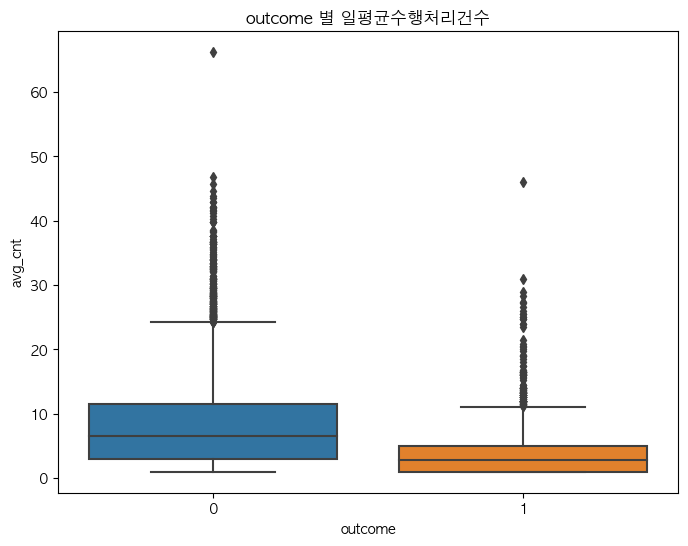

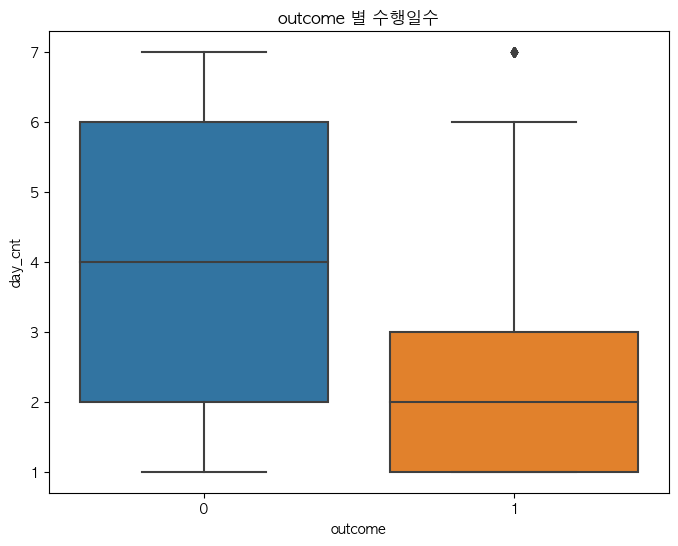

In [92]:
plt.figure(figsize=(8,6))
sns.boxplot(data=data_filter, x='outcome', y='avg_cnt')
plt.title("outcome 별 일평균수행처리건수")
#plt.savefig("prj-ML-model-LT_OV30/graph/boxplot_per_recomm_by_reg_hour.png")
plt.show()

plt.figure(figsize=(8,6))
sns.boxplot(data=data_filter, x='outcome', y='day_cnt')
plt.title("outcome 별 수행일수")
#plt.savefig("prj-ML-model-LT_OV30/graph/boxplot_per_recomm_by_reg_hour.png")
plt.show()

In [93]:
def remove_outliers(df, column):
    Q1 = df.groupby('outcome')[column].quantile(0.25)
    Q3 = df.groupby('outcome')[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[df.apply(lambda x: (x[column] >= lower_bound[x['outcome']]) & 
                                 (x[column] <= upper_bound[x['outcome']]), axis=1)]

# 'avg_cnt'와 'day_cnt'에 대한 아웃라이어 제거
data_filtered_avg = remove_outliers(data_filter, 'avg_cnt')
data_filtered_both = remove_outliers(data_filtered_avg, 'day_cnt')

print(data_filtered_both.shape) #6139


(6139, 11)


# 3. train, test set split 

In [94]:
X_train, X_test, y_train, y_test = train_test_split(
    data_filtered_both[['day_cnt', 'avg_cnt']], 
    data_filtered_both['outcome'],
    train_size = 0.7,
    test_size = 0.3,
    random_state=0,  
    stratify=data_filtered_both['outcome']  
)
print(X_train.shape, X_test.shape) # 4,297, 1,842 

print(y_train. value_counts())
print(y_test.value_counts())

(4297, 2) (1842, 2)
outcome
0    2942
1    1355
Name: count, dtype: int64
outcome
0    1261
1     581
Name: count, dtype: int64


## 3. ROC curve 

In [95]:
def create_and_save_roc_plot(data, variable_name):
    
    y_true = data['outcome'].values
    y_scores = data[variable_name].values
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    sensitivity = tpr[optimal_idx]
    specificity = 1 - fpr[optimal_idx]

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color='red', label=f'AUC = {roc_auc:.3f}')
    plt.fill_between(fpr, tpr, color="#D1F2EB")
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Optimal Threshold')
    plt.text(fpr[optimal_idx] + 0.02, tpr[optimal_idx] - 0.1, f'Sensitivity = {sensitivity:.3f}\nSpecificity = {specificity:.3f}\nOptimal threshold (cut-off value) = {optimal_threshold:.3f}', fontsize=12)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    
    return optimal_threshold
 

inf

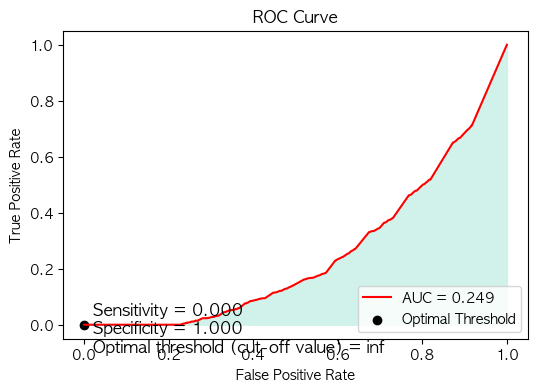

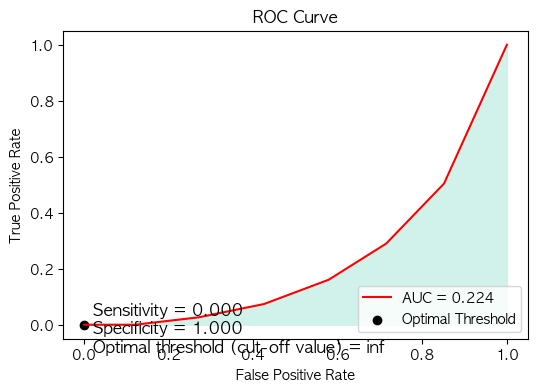

In [96]:
create_and_save_roc_plot(data_filtered_both, 'avg_cnt')
create_and_save_roc_plot(data_filtered_both, 'day_cnt')

## 4. 로지스틱 회귀분석 - coef, accuracy 확인 

In [86]:
X_train_sm = sm.add_constant(X_train)
model_2 = sm.Logit(y_train, X_train_sm)
result = model_2.fit()

print(result.summary())

X_test_sm = sm.add_constant(X_test)
y_pred = result.predict(X_test_sm)

y_pred_label = [0 if prob < 0.5 else 1 for prob in y_pred]

accuracy = accuracy_score(y_test, y_pred_label)
print(f"\nAccuracy: {accuracy}")


Optimization terminated successfully.
         Current function value: 0.490890
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                 4297
Model:                          Logit   Df Residuals:                     4294
Method:                           MLE   Df Model:                            2
Date:                Tue, 24 Oct 2023   Pseudo R-squ.:                  0.2124
Time:                        19:03:57   Log-Likelihood:                -2109.4
converged:                       True   LL-Null:                       -2678.3
Covariance Type:            nonrobust   LLR p-value:                7.842e-248
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3005      0.076     17.110      0.000       1.152       1.449
day_cnt       -0.4369      0.

Accuracy: 0.754071661237785

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1261
           1       0.62      0.58      0.60       581

    accuracy                           0.75      1842
   macro avg       0.71      0.71      0.71      1842
weighted avg       0.75      0.75      0.75      1842



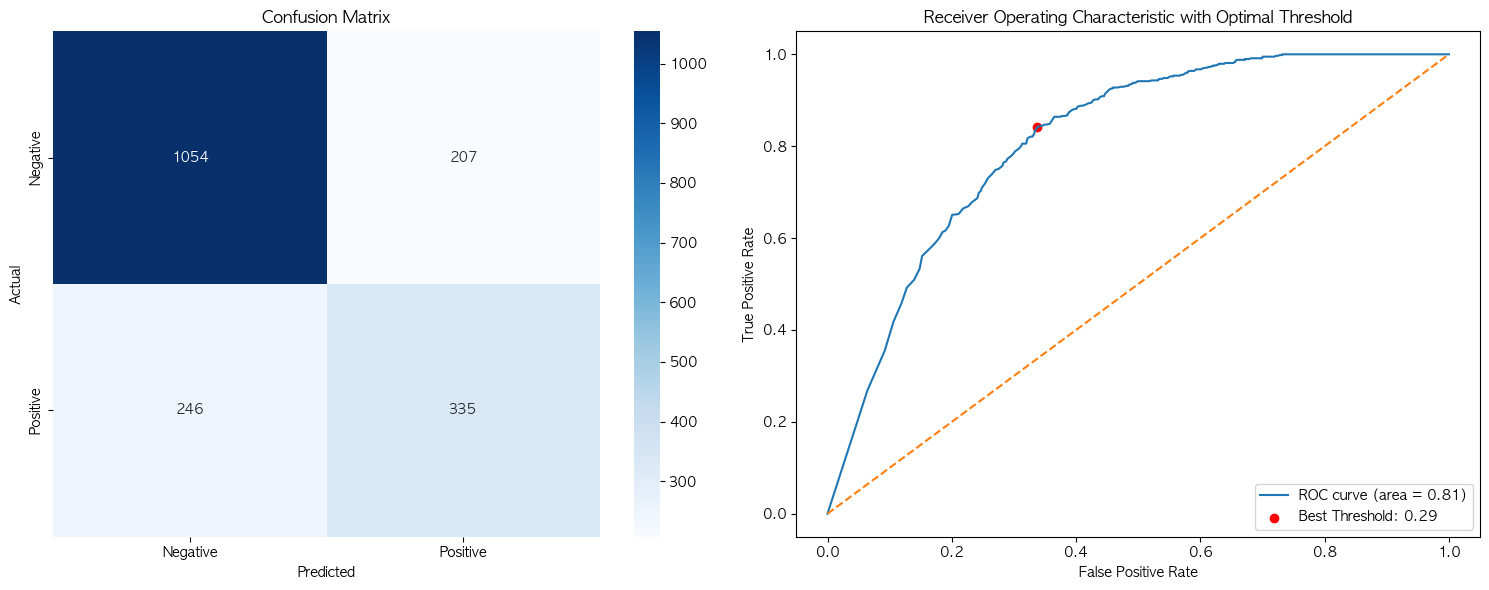

In [99]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]  # 예측 확률

# accuracy 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}\n")

# confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# 최적의 임계값 찾기
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# graph
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# 
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax[0])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
ax[0].set_title('Confusion Matrix')

# ROC graph
ax[1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
ax[1].plot([0, 1], [0, 1], linestyle='--')  # 참조선
ax[1].scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Best Threshold: {optimal_threshold:.2f}')  # 최적의 임계값 표시
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic with Optimal Threshold')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


Adjusted Accuracy (with threshold 0.29): 0.7176981541802389

Adjusted Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76      1261
           1       0.53      0.82      0.65       581

    accuracy                           0.72      1842
   macro avg       0.71      0.75      0.71      1842
weighted avg       0.78      0.72      0.73      1842

[[845 416]
 [104 477]]


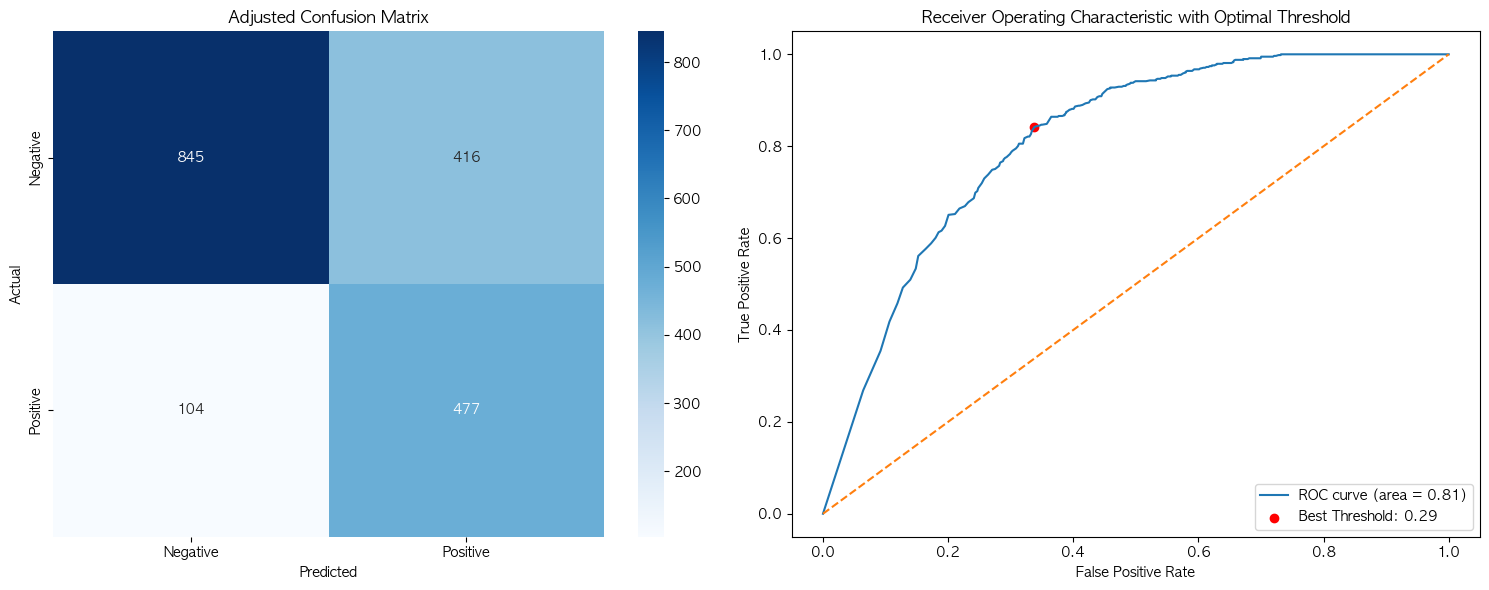

In [100]:
y_pred_adjusted = (y_probs >= 0.29).astype(int)

adjusted_accuracy = accuracy_score(y_test, y_pred_adjusted)
print(f"Adjusted Accuracy (with threshold 0.29): {adjusted_accuracy}\n")

adjusted_cm = confusion_matrix(y_test, y_pred_adjusted)
print("Adjusted Classification Report:")
print(classification_report(y_test, y_pred_adjusted))


fig, ax = plt.subplots(1, 2, figsize=(15, 6))
print(adjusted_cm)

sns.heatmap(adjusted_cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax[0])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
ax[0].set_title('Adjusted Confusion Matrix')


ax[1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
ax[1].plot([0, 1], [0, 1], linestyle='--')  # 참조선
ax[1].scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Best Threshold: {optimal_threshold:.2f}')  # 최적의 임계값 표시
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic with Optimal Threshold')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


In [111]:
print(f"Minimum of day_cnt: {X_test['day_cnt'].min()}")
print(f"Maximum of day_cnt: {X_test['day_cnt'].max()}")
print(f"Minimum of avg_cnt: {X_test['avg_cnt'].min()}")
print(f"Maximum of avg_cnt: {X_test['avg_cnt'].max()}")

Minimum of day_cnt: 1
Maximum of day_cnt: 7
Minimum of avg_cnt: 1.0
Maximum of avg_cnt: 24.142857142857142


In [112]:
# 가능한 day_cnt 및 avg_cnt 값의 범위 설정 (실제 상황에 맞게 조정)
day_cnt_range = np.linspace(X_test['day_cnt'].min(), X_test['day_cnt'].max(), 1000)
avg_cnt_range = np.linspace(X_test['avg_cnt'].min(), X_test['avg_cnt'].max(), 1000)

# 계수 및 절편 가져오기
coef = model.coef_[0]
intercept = model.intercept_[0]

# 최적의 조합 찾기
best_combinations = []

for day in day_cnt_range:
    for avg in avg_cnt_range:
        linear_part = intercept + coef[0] * day + coef[1] * avg

        if linear_part > 0:
            best_combinations.append((day, avg))

best_combinations = np.array(best_combinations)

# 중앙값
median_idx = len(best_combinations) // 2 
selected_combination = best_combinations[median_idx]

print(f"Optimal day_cnt: {selected_combination[0]}")
print(f"Optimal avg_cnt: {selected_combination[1]}")

# 평균값
mean_day_cnt = np.mean(best_combinations[:, 0])
mean_avg_cnt = np.mean(best_combinations[:, 1])

print(f"Mean day_cnt: {mean_day_cnt}")
print(f"Mean avg_cnt: {mean_avg_cnt}")

Optimal day_cnt: 1.4684684684684686
Optimal avg_cnt: 1.718146718146718
Mean day_cnt: 1.531792120150734
Mean avg_cnt: 2.394887514754329


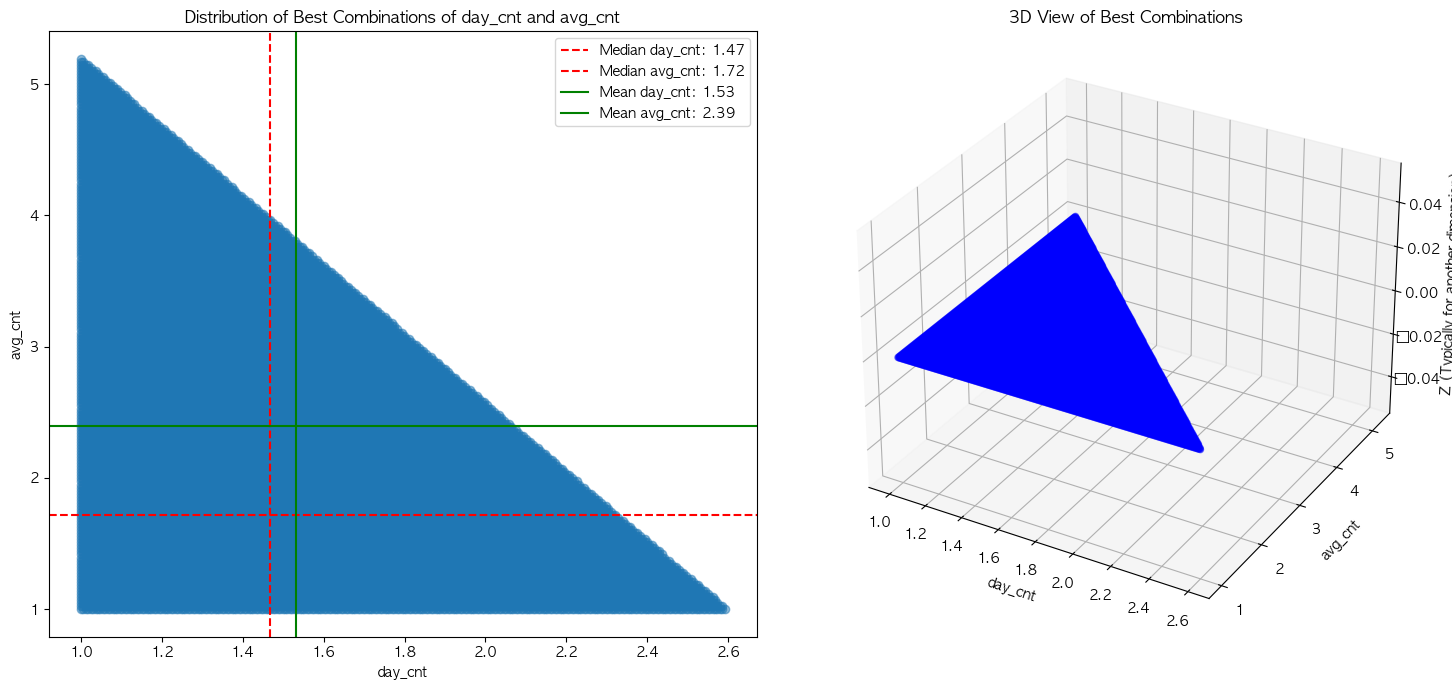

In [113]:
day_values = best_combinations[:, 0]
avg_values = best_combinations[:, 1]

fig = plt.figure(figsize=(15, 7))

#2D 산점도
ax1 = fig.add_subplot(1, 2, 1)  # 1행 2열의 첫 번째
ax1.scatter(day_values, avg_values, alpha=0.5)
ax1.axvline(x=selected_combination[0], color='r', linestyle='--', label=f'Median day_cnt: {selected_combination[0]:.2f}')
ax1.axhline(y=selected_combination[1], color='r', linestyle='--', label=f'Median avg_cnt: {selected_combination[1]:.2f}')
ax1.axvline(x=mean_day_cnt, color='g', linestyle='-', label=f'Mean day_cnt: {mean_day_cnt:.2f}')
ax1.axhline(y=mean_avg_cnt, color='g', linestyle='-', label=f'Mean avg_cnt: {mean_avg_cnt:.2f}')
ax1.set_xlabel('day_cnt')
ax1.set_ylabel('avg_cnt')
ax1.set_title('Distribution of Best Combinations of day_cnt and avg_cnt')
ax1.legend()

# 3D 산점도
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # 1행 2열의 두 번째
z_values = np.zeros(len(day_values))  # Z 값 설정 (여기서는 0으로 설정)
ax2.scatter(day_values, avg_values, z_values, c='b', marker='o', alpha=0.5)
ax2.set_xlabel('day_cnt')
ax2.set_ylabel('avg_cnt')
ax2.set_zlabel('Z (Typically for another dimension)')
ax2.set_title('3D View of Best Combinations')

plt.tight_layout()
plt.show()
